<a href="https://colab.research.google.com/github/Aviral-Aggarwal/Retail_models/blob/master/retail_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Data loading, Compression and Viewing
NOTE: the merging is done in place, that is why do not re run the cells, it created lots of errors earlier on

In [ ]:
#New version of numpy is there, using the upgraded one
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

from math import ceil

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

#the sales training data has more than 1900 columns
pd.set_option('max_columns', 100)
#These are used for better plotting, check them later or ask about them
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

This function is mostly copied, I am not sure how the data compression exactly works, but it is standard and creates no errors

In [ ]:
input_dir = '/content/gdrive/My Drive/m5-forecasting-accuracy/'

#CHECK AGAIN HOW THIS IS WORKING, IS IT ZIP MECHANISM OR SOMETHING ELSE
#Standard function, copied from stack exchange
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def read_data(input_dir):
    sell_prices_df = pd.read_csv(input_dir+'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(df=sell_prices_df, verbose=True)
    print('The shape of sell prices is ', sell_prices_df.shape)
    
    sales_train_validation_df = pd.read_csv(input_dir+'sales_train_validation.csv')
    sales_train_validation_df = reduce_mem_usage(df=sales_train_validation_df, verbose=True)
    print('The shape of sales data is ', sales_train_validation_df.shape)
    
    calendar_df = pd.read_csv(input_dir+'calendar.csv')
    calendar_df = reduce_mem_usage(df=calendar_df, verbose=True)
    print('The shape of the calendar is ', calendar_df.shape)
    
    return sell_prices_df, sales_train_validation_df, calendar_df

In [ ]:
t1 = time.time()
sell_df, sales_df, calendar = read_data(input_dir)
t2 = time.time()
print('Time taken for loading data is ', (t2-t1))
#!!!!!!!!!!!
#Sell prices is displaying and loading here, but in the end when I do operations on it, it hangs

Mem. usage decreased to 130.48 Mb (37.5% reduction)
The shape of sell prices is  (6841121, 4)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
The shape of sales data is  (30490, 1919)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
The shape of the calendar is  (1969, 14)
Time taken for loading data is  123.21620488166809


In [ ]:
calendar.shape
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


Check the missing weeks' data and why the head is starting from 11325 and not 11101 as per the calendar

In [ ]:
sell_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


# Data aggregation and merging

The data list created here will be used later.
Even though the calendar has 1969 dates, the other data is available only for 1913 days. I am assuming that since the data is from a competition, the rest for testing.

In [ ]:
import datetime
date_index = calendar['date']
dates = date_index[0:1819]
dates_list = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

This is the most commonly used data frame later on, all merging and other operations are done using this particular one

In [ ]:
#This is the aggregated per category and per store
data = pd.DataFrame(sales_df.groupby(by = ['cat_id', 'dept_id', 'item_id', 'store_id']).sum())
data.head(n=15)

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  \
cat_id dept_id item_id     store_id                                           
FOODS  FOODS_1 FOODS_1_001 CA_1        3    0    0    1    4    2    0    2   
                           CA_2        2    0    0    0    1    0    8    0   
                           CA_3        1    2    1    1    1    2    0    1   
                           CA_4        0    1    1    1    1    1    0    0   
                           TX_1        0    1    1    0    0    0    0    0   
                           TX_2        0    0    1    2    0    4    0    0   
                           TX_3        0    0    0    0    0    0    0    0   
                           WI_1        0    2    0    1    0    5    0    0   
                           WI_2        0    0    0    0    0    1    2    1   
                           WI_3        0    0    0    0    0    3    0    0   
               FOODS_1_002 CA_1        0    1    0    1    1    1    0    0   
                           CA_2        2    1    1    0    2    2    0    1   
                           CA_3        1    0    1    2    0    0    0    1   
                           CA_4        0    1    2    1    0    0    0    0   
                           TX_1        0    0    0    0    0    0    0    0   

                                     d_9  d_10  d_11  d_12  d_13  d_14  d_15  \
cat_id dept_id item_id     store_id                                            
FOODS  FOODS_1 FOODS_1_001 CA_1        0     0     0     0     3     1     3   
                           CA_2        4     1     2     1     1     3     4   
                           CA_3        1     1     0     0     3     3     2   
                           CA_4        0     0     0     0     1     2     1   
                           TX_1        2     1     0     0     0     1     0   
                           TX_2        2     2     0     1     2     0     0   
                           TX_3        0     0     4     1     0     0     0   
                           WI_1        1     1     0     0     1     0     2   
                           WI_2        1     1     0     0     0     1     2   
                           WI_3        0     3     0     2     1     4     2   
               FOODS_1_002 CA_1        0     0     1     1     0     2     0   
                           CA_2        0     0     1     0     0     0     5   
                           CA_3        1     0     1     0     0     0     1   
                           CA_4        0     1     0     1     0     0     0   
                           TX_1        0     0     0     1     0     2     1   

                                     d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
cat_id dept_id item_id     store_id                                             
FOODS  FOODS_1 FOODS_1_001 CA_1         0     2     1     2     0     2     1   
                           CA_2         1     2     2     2     0     1     1   
                           CA_3         7     1     2     4     0     1     1   
                           CA_4         0     1     0     0     1     0     2   
                           TX_1         0     0     0     0     0     0     0   
                           TX_2         4     4     1     0     1     2     0   
                           TX_3         0     0     2     1     1     0     1   
                           WI_1         0     0     1     2     0     7     0   
                           WI_2         0     1     1     1     1     4     1   
                           WI_3         6     0     0     0     3     0     2   
               FOODS_1_002 CA_1         1     0     0     0     0     0     0   
                           CA_2         3     0     0     0     0     0     3   
                           CA_3         0     0     0     0     0     1     0   
                           CA_4         0     0     0     1     0     0     0   
                           TX_1     

The complete sales for the 6 year time period of each item in each of the stores. The sales_df has it spread out onto the individual dates.

1. sales has the summed up columns according to the food categories, and department id's
2. stores groups them by the individual stores

In [ ]:
sales = pd.DataFrame(data.sum(axis = 1))
sales.rename(columns = {0:'sales'},inplace=True)
sales.head(15)

sales
cat_id dept_id item_id     store_id       
FOODS  FOODS_1 FOODS_1_001 CA_1       1503
                           CA_2       2214
                           CA_3       2302
                           CA_4        688
                           TX_1       1119
                           TX_2       1112
                           TX_3        785
                           WI_1       1086
                           WI_2        875
                           WI_3        563
               FOODS_1_002 CA_1        914
                           CA_2       1154
                           CA_3        603
                           CA_4        640
                           TX_1        323

Sales has info for all the items, and therefore I am assuming there are roughly 3049 items we are talking about.

In [ ]:
sales.shape

(30490, 1)

Use the second statement in case a generic graph is required about a certain category

In [ ]:
#Same procedure as above, but now the tables are store-wise instead of item-wise
stores_df = pd.DataFrame(sales_df.groupby(by = ['store_id', 'cat_id']).sum())
#stores_df = pd.DataFrame(sales_df.groupby(by = ['store_id', 'cat_id','dept_id']).sum())

stores = pd.DataFrame(stores_df.sum(axis=1))
stores.rename(columns = {0:'Total sales'}, inplace=True)
stores

Total sales
store_id cat_id                
CA_1     FOODS        5380828.0
         HOBBIES       876678.0
         HOUSEHOLD    1440710.0
CA_2     FOODS        3480259.0
         HOBBIES       637803.0
         HOUSEHOLD    1567413.0
CA_3     FOODS        7515790.0
         HOBBIES       960947.0
         HOUSEHOLD    2711443.0
CA_4     FOODS        2819425.0
         HOBBIES       564455.0
         HOUSEHOLD     719796.0
TX_1     FOODS        3778209.0
         HOBBIES       429084.0
         HOUSEHOLD    1387999.0
TX_2     FOODS        5015124.0
         HOBBIES       635997.0
         HOUSEHOLD    1563263.0
TX_3     FOODS        4163088.0
         HOBBIES       527258.0
         HOUSEHOLD    1398984.0
WI_1     FOODS        3438352.0
         HOBBIES       655696.0
         HOUSEHOLD    1055014.0
WI_2     FOODS        4768184.0
         HOBBIES       370214.0
         HOUSEHOLD    1405614.0
WI_3     FOODS        4730680.0
         HOBBIES       466668.0
         HOUSEHOLD    1230434.0

What exactly is the use of the reset function and what does it do. There were errors and on stack ex. people just recommended it, but ask why does it have to be used. Also what exactly is the middle grey line representing, the variation or min-max, and if those then the variation amongst what parameter ?????

Text(0.5, 1.0, 'Store-wise sales across the categories')

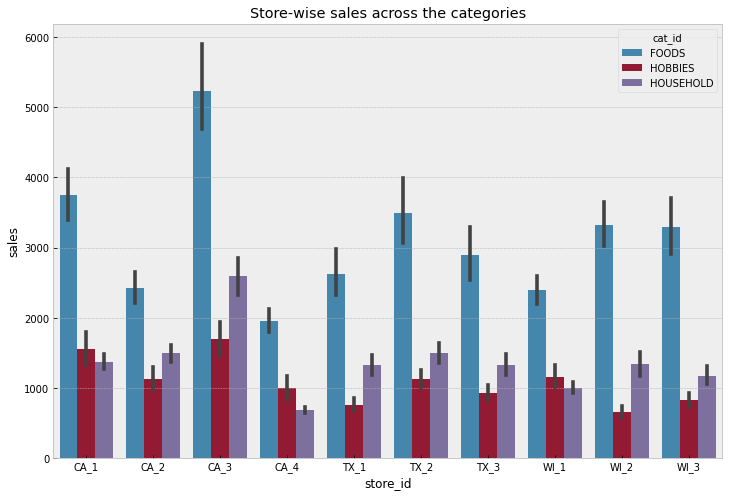

In [ ]:
import seaborn as sns

sale = sales.copy().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x= sale['store_id'],y=sale['sales'],hue=sale['cat_id'])
plt.title('Store-wise sales across the categories')

In [ ]:
calendar_orig = calendar.copy()
calendar = calendar[0:1913]
#While merging and plotting, only the first 1913 days have all available data
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
#Unable to merge dataframes, trying an alternate method; kind of a hack

#food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))[0].tolist()
#hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))[0].tolist()
#house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))[0].tolist()

#calendar['food'] = food
#calendar['hobbies'] = hobbies
#calendar['households'] = house
#calendar

In [ ]:
#MERGING THE SALES DATA WITH THE CALENDAR

food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))
hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))
house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))

calendar = pd.merge(calendar,food,how = 'left',left_on=calendar['d'],right_on = food.index)
del calendar['key_0']
calendar.rename(columns = {0:'food'},inplace = True)
calendar = pd.merge(calendar,hobbies,how = 'left',left_on=calendar['d'],right_on = hobbies.index)
del calendar['key_0']
calendar.rename(columns = {0:'hobby'},inplace = True)
calendar = pd.merge(calendar,house,how = 'left',left_on=calendar['d'],right_on = house.index)
del calendar['key_0']
calendar.rename(columns = {0:'house'},inplace = True)

calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobby,house
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248


Taking daily Sales data for each category from each store and merging with calendar data. DO NOT run this cell twice, it will creates issues later. I am taking out the individual columns from the data DataFrame and then appending them to the calendar columns. There are supposed to be 47 columns in the output of the next cell.

In [ ]:
l1 = ['FOODS','HOBBIES','HOUSEHOLD']
l2 = list(sales_df['store_id'].unique())
for cat in l1:
    for store in l2:
      #the next statement first gets the category data, and within that store data, hence level =2
        tmp = pd.DataFrame(data.xs(cat).xs(store,level = 2 ).sum(axis = 0))
        tmp.reset_index(inplace = True)
        col_name = (cat+'_'+store).lower()
        tmp.rename(columns = {0:col_name},inplace = True)
        calendar = pd.concat([calendar,tmp[col_name]],axis = 1)
        
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobby,house,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3,hobbies_ca_1,hobbies_ca_2,hobbies_ca_3,hobbies_ca_4,hobbies_tx_1,hobbies_tx_2,hobbies_tx_3,hobbies_wi_1,hobbies_wi_2,hobbies_wi_3,household_ca_1,household_ca_2,household_ca_3,household_ca_4,household_tx_1,household_tx_2,household_tx_3,household_wi_1,household_wi_2,household_wi_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689,3239,2193,3446,1223,1781,2788,2284,1581,1615,3028,556,538,550,158,251,385,243,615,190,278,542,763,743,244,524,679,503,508,451,732
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634,3137,1921,3535,1269,1903,2870,2257,1327,1433,3106,498,397,430,236,264,359,247,443,127,356,520,728,862,272,520,708,502,424,362,736
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927,2008,1289,2701,946,1377,2082,1665,977,1586,2543,415,368,438,251,107,229,190,323,113,248,393,464,646,189,338,420,370,262,319,526
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865,2258,1540,3064,1002,1643,2180,1647,935,2013,2596,392,350,424,239,248,359,202,137,124,194,401,434,744,199,367,415,320,179,385,421
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729,2032,1278,2761,1107,1329,1890,1383,2,967,1854,268,296,364,253,102,257,142,0,58,74,330,368,692,176,263,345,201,0,150,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239,2490,2506,3286,1581,1834,2196,2212,2290,3005,2232,363,344,534,405,273,373,334,326,276,244,869,841,1415,514,794,815,769,626,913,683
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363,2533,2261,3056,1629,1777,2239,2151,2285,3078,2308,410,271,540,369,219,340,323,397,281,203,766,771,1422,460,780,867,906,642,1034,715
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728,2960,2871,3409,1751,1922,2547,2370,2790,3419,2665,527,485,598,405,271,388,397,415,303,296,900,1101,1616,472,829,967,924,786,1266,867
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248,3655,3760,4459,1971,2319,2930,2600,3242,3751,3240,670,542,765,390,289,436,497,503,282,413,1252,1582,2195,593,1092,1117,986,1027,1371,1033


# Plots for viewing trends
These are the overall plots for annual or combined data on the big calendar dataframe for viewing each of its columns.

1.   Subplots = True, gives the annual data and false gives 30 day moving average
2.   The first argument is the list of all the lines that are to be plotted together on one plot
3.   The scaled one just uses standard minmax scaler otherwise the food plot overshadows all other plots due to considerably higher sales

Note: Check what exactly is the minmax scaler's back ground operation



In [ ]:
#This is the function used for plotting monthly, weekly and yearly data.
grps = calendar.groupby(by=['year','month'])
def plot_trend(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(3,2,figsize = (14,10))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0,0])
                check.xs(2012).plot(ax=a[0,1])
                check.xs(2013).plot(ax=a[1,0])
                check.xs(2014).plot(ax=a[1,1])
                check.xs(2015).plot(ax=a[2,0])
                check.xs(2016).plot(ax=a[2,1])
                
        else:
            check = grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0,0])
            check.xs(2012).plot(ax=a[0,1])
            check.xs(2013).plot(ax=a[1,0])
            check.xs(2014).plot(ax=a[1,1])
            check.xs(2015).plot(ax=a[2,0])
            check.xs(2016).plot(ax=a[2,1])
        
        a[0,0].title.set_text('2011')
        a[0,1].title.set_text('2012')
        a[1,0].title.set_text('2013')
        a[1,1].title.set_text('2014')
        a[2,0].title.set_text('2015')
        a[2,1].title.set_text('2016')
        
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            calendar.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

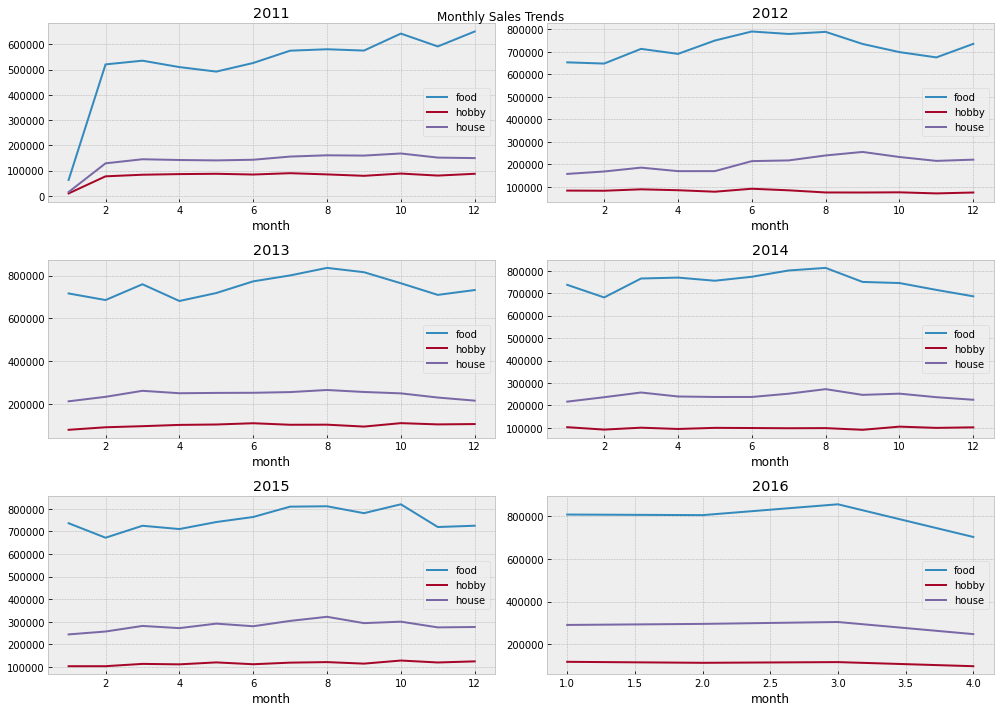

In [ ]:
plot_trend(['food','hobby','house'],subplots = True)

NOTE: The initial part of the 2011 graph is not an outlier, just that there is data only for few days that month.

In [ ]:
#Using minscaler here, otherwise the high sales of food overshadows all other sales and makes graphs harder to read
cols = calendar.iloc[:,14:].columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform( calendar.iloc[:,15:]))
for i in range(0,len(cols)):
    scaled_df.rename(columns = {i:cols[i]},inplace = True)
cln_scaled = calendar.iloc[:,:14]
cln_scaled = pd.concat([calendar.iloc[:,:14],scaled_df],axis = 1)

The next function is pretty much the same as the previous one, just using the cln_scaled instead of calendar

In [ ]:
new_grps = cln_scaled.groupby(by=['year','month'])
def plot_trend_scaled(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(6,1,figsize = (14,36))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = new_grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0])
                check.xs(2012).plot(ax=a[1])
                check.xs(2013).plot(ax=a[2])
                check.xs(2014).plot(ax=a[3])
                check.xs(2015).plot(ax=a[4])
                check.xs(2016).plot(ax=a[5])
                
        else:
            check = new_grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0])
            check.xs(2012).plot(ax=a[1])
            check.xs(2013).plot(ax=a[2])
            check.xs(2014).plot(ax=a[3])
            check.xs(2015).plot(ax=a[4])
            check.xs(2016).plot(ax=a[5])
        a[0].title.set_text('2011')
        a[1].title.set_text('2012')
        a[2].title.set_text('2013')
        a[3].title.set_text('2014')
        a[4].title.set_text('2015')
        a[5].title.set_text('2016')
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            cln_scaled.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

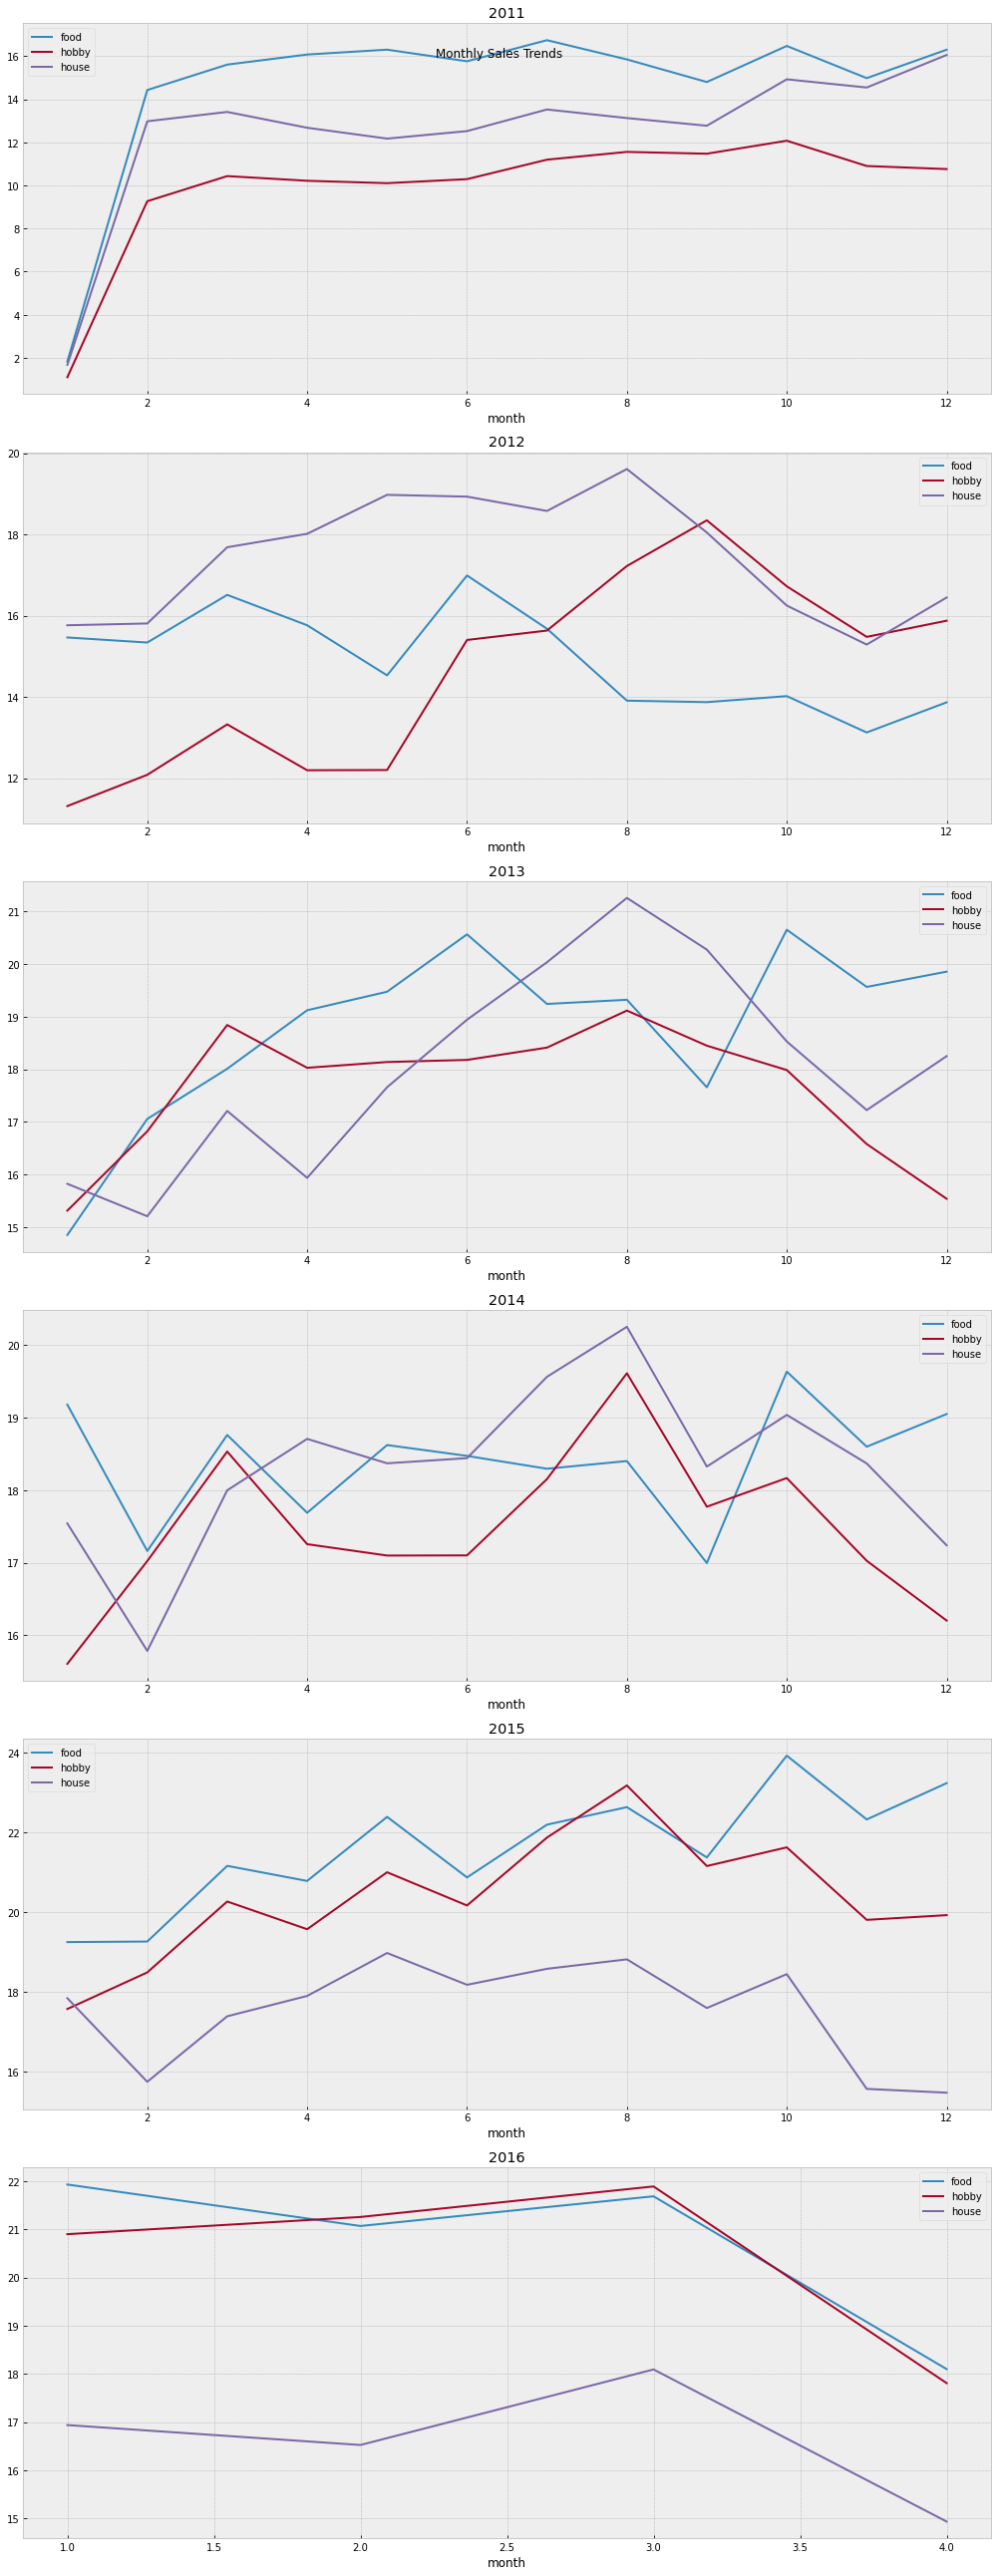

In [ ]:
plot_trend_scaled(['food','hobby','house'],subplots = True)

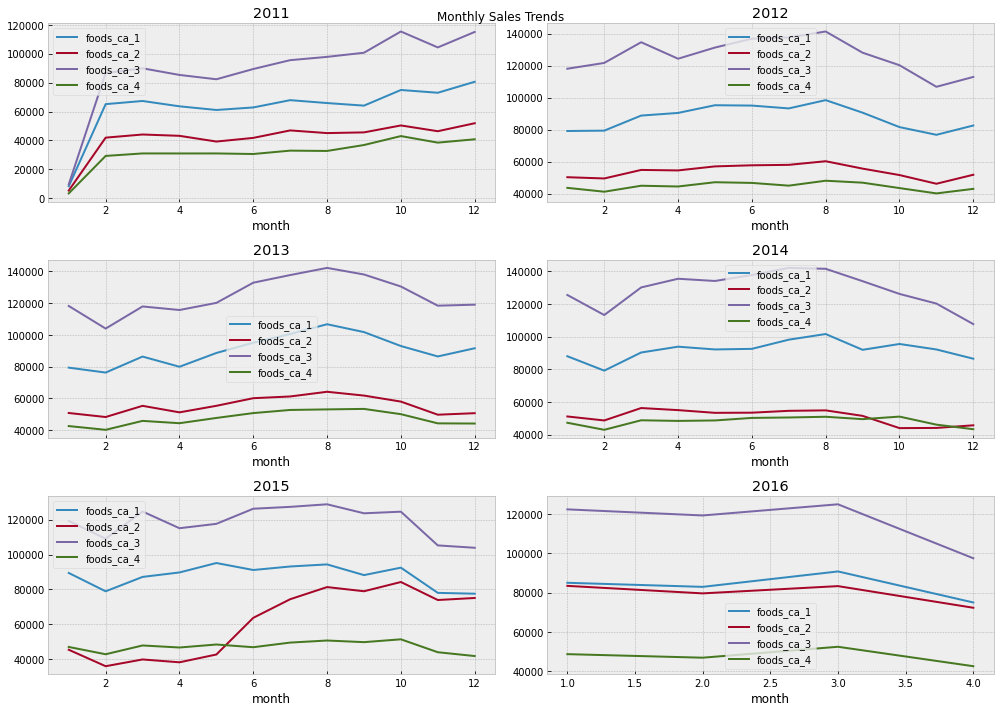

In [ ]:
plot_trend(['foods_ca_1','foods_ca_2','foods_ca_3','foods_ca_4'],subplots = True)

The previous two functions have a bit of flexibility over the available 47 columns in the master calendar DataFrame, just change the list of items.
1. Also you can set subplots to False to get the annual data, just like the financial data
2. Moving Averages can be computed this way, few examples are available below

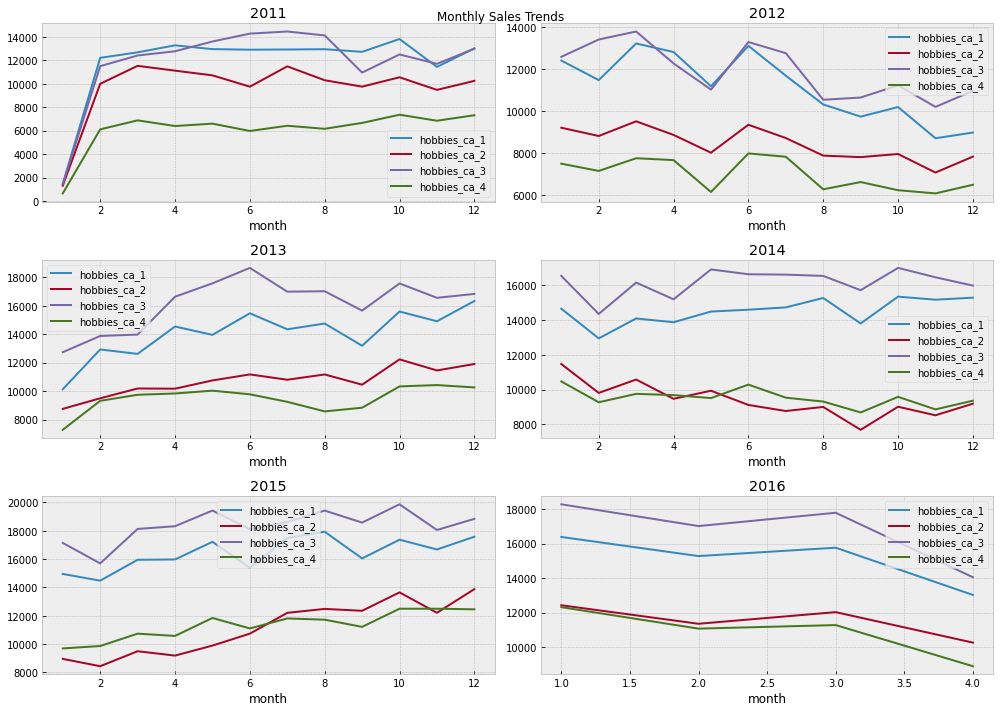

In [ ]:
plot_trend(['hobbies_ca_1','hobbies_ca_2','hobbies_ca_3','hobbies_ca_4'],subplots = True)

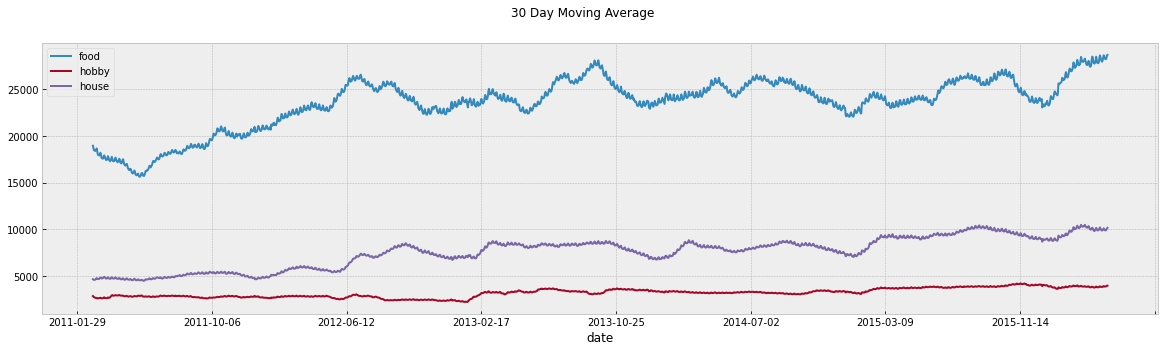

In [ ]:
plot_trend(['food','hobby', 'house'], subplots=False)

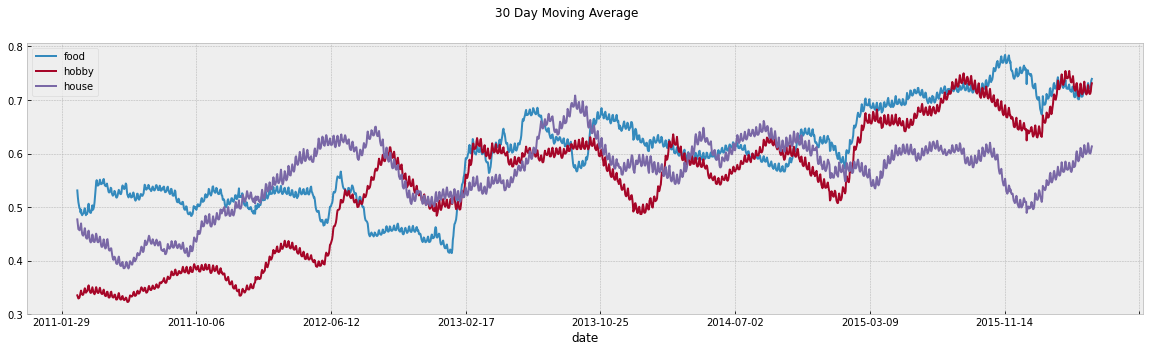

In [ ]:
plot_trend_scaled(['food','hobby', 'house'], subplots=False)

# The Real plots from where actual observations can be made

In [ ]:
# The ideas and codes after this are somewhat redundant, but for analysis for different things and time scales

In [ ]:
groups = calendar.groupby(by=['year','month','date']).sum()
def monthly_sale(month,item,years):
    tmp = groups.xs(month,level=1)[item].unstack(level=0)
    tmp.reset_index(inplace=True)
    #check if there is an alternate way to handle the above error
    tmp['date'] = pd.to_datetime(tmp['date'], errors='coerce')
    tmp['days'] = tmp['date'].dt.day
    fig,ax = plt.subplots(figsize = (12,8))
    for year in years:
        plt.plot(tmp['days'],tmp[year],axes = ax,label=year)
        plt.legend()
        
groups

wm_yr_wk  wday  snap_CA  snap_TX  snap_WI   food  \
year month date                                                           
2011 1     2011-01-29     11101     1        0        0        0  23178   
           2011-01-30     11101     2        0        0        0  22758   
           2011-01-31     11101     3        0        0        0  17174   
     2     2011-02-01     11101     4        1        1        0  18878   
           2011-02-02     11101     5        1        0        1  14603   
...                         ...   ...      ...      ...      ...    ...   
2016 4     2016-04-20     11612     5        0        0        0  23632   
           2016-04-21     11612     6        0        0        0  23317   
           2016-04-22     11612     7        0        0        0  26704   
           2016-04-23     11613     1        0        0        0  31927   
           2016-04-24     11613     2        0        0        0  32654   

                       hobby  house  foods_ca_1  foods_ca_2  foods_ca_3  \
year month date                                                           
2011 1     2011-01-29   3764   5689        3239        2193        3446   
           2011-01-30   3357   5634        3137        1921        3535   
           2011-01-31   2682   3927        2008        1289        2701   
     2     2011-02-01   2669   3865        2258        1540        3064   
           2011-02-02   1814   2729        2032        1278        2761   
...                      ...    ...         ...         ...         ...   
2016 4     2016-04-20   3472   8239        2490        2506        3286   
           2016-04-21   3353   8363        2533        2261        3056   
           2016-04-22   4085   9728        2960        2871        3409   
           2016-04-23   4787  12248        3655        3760        4459   
           2016-04-24   4683  12458        4053        4012        4698   

                       foods_ca_4  foods_tx_1  foods_tx_2  foods_tx_3  \
year month date                                                         
2011 1     2011-01-29        1223        1781        2788        2284   
           2011-01-30        1269        1903        2870        2257   
           2011-01-31         946        1377        2082        1665   
     2     2011-02-01        1002        1643        2180        1647   
           2011-02-02        1107        1329        1890        1383   
...                           ...         ...         ...         ...   
2016 4     2016-04-20        1581        1834        2196        2212   
           2016-04-21        1629        1777        2239        2151   
           2016-04-22        1751        1922        2547        2370   
           2016-04-23        1971        2319        2930        2600   
           2016-04-24        2043        2491        2853        2421   

                       foods_wi_1  foods_wi_2  foods_wi_3  hobbies_ca_1  \
year month date                                                           
2011 1     2011-01-29        1581        1615        3028           556   
           2011-01-30        1327        1433        3106           498   
           2011-01-31         977        1586        2543           415   
     2     2011-02-01         935        2013        2596           392   
           2011-02-02           2         967        1854           268   
...                           ...         ...         ...           ...   
2016 4     2016-04-20        2290        3005        2232           363   
           2016-04-21        2285        3078        2308           410   
           2016-04-22        2790        3419        2665           527   
           2016-04-23        3242        3751        3240           670   
           2016-04-24        3317        3659        3107           714   

                       hobbies_ca_2  hobbies_ca_3  hobbies_ca_4  hobbies_tx_1  \
year month date                                                 

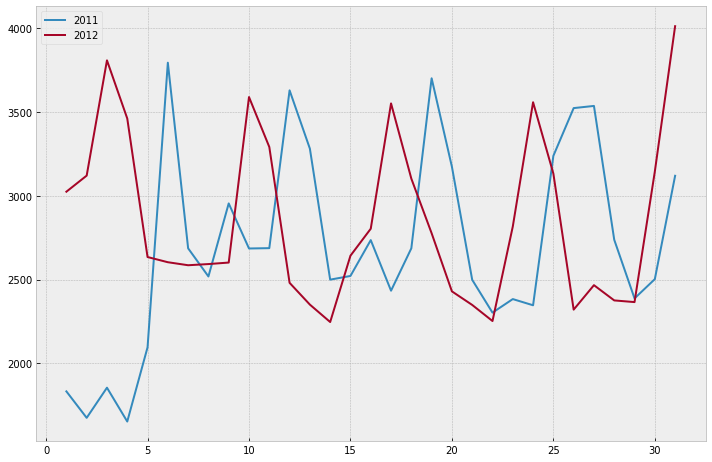

In [ ]:
# the monthly comparison of march for all the six years
#monthly_sale(3,'hobby',[2011,2012,2013,2014,2015,2016])
#the above graph was all over the place
monthly_sale(3,'hobby',[2011,2012])

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
calendar['days'] = calendar['date'].dt.day

Most of this code is copied, still a bit unclear on how to make such plots

In [ ]:
tmpdf = calendar[~calendar['event_name_1'].isnull()]
def monthly_sale_event(month,item,year):
    tmp = groups.xs(month,level=1)[item].unstack(level=0)
    tmp.reset_index(inplace=True)
    tmp['date'] = pd.to_datetime(tmp['date'], errors='coerce')
    tmp['days'] = tmp['date'].dt.day
    fig,ax = plt.subplots(figsize = (12,8))
    tmpyr=tmpdf[tmpdf.year == year]
    l1=list(tmpyr[tmpyr.month==month]['days'])
    l2=list(tmpyr[tmpyr.month==month]['event_name_1'])
    print(l2)
    plt.plot(tmp['days'],tmp[year],axes = ax,label=year)
    plt.legend()
    axe = plt.gca()
    start,end = axe.get_ylim()[0],axe.get_ylim()[1]
    plt.vlines(l1,start,end,linestyles='--',color='r',alpha = 0.5)
    for i in range(0,len(l2)):
        plt.text(l1[i],end,l2[i])
    plt.show()

['Chanukah End', 'Christmas']


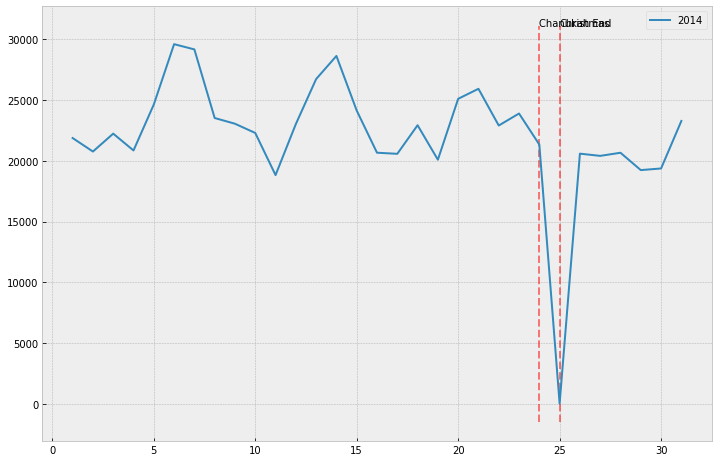

In [ ]:
monthly_sale_event(12, 'food', 2014)

#This example does not show anything, but enter 12 and then see that near christmas
#There are distinct and specific changes in pattern

The most flexible and widely used function


1.   The first argument of time can be anything we want to plot on the x-axis; generally daily, wday, month and year as the arguments
2.   The second argument can be any of the 33 available columns in calendat that we want to plot on the yaxis
3.   The last argument is the type of statistic that we want to calculate

I have added 4 stats for the last one, there are 20 options that were listed, if any others are required then just add more if else statements

In [ ]:
def sale_trend(time,item,cal_type):
    if time == 'daily':
        calendar.set_index('date')[item].plot(figsize = (15,5))
        calendar.set_index('date')[item].rolling(30).mean().plot(figsize = (15,5))
    else:
        if type(item) == list:
            fig,ax = plt.subplots(figsize = (15,5))
            for prod in item:
                if cal_type == 'sum':
                    cln.groupby(time)[item].sum().plot(figsize=(15,5),axes = ax)
                elif cal_type == 'mean':
                    cln.groupby(time)[item].mean().plot(figsize=(15,5),axes = ax)
        else:
            if cal_type == 'sum':
                calendar.groupby(time)[item].sum().plot(figsize=(15,5))
            elif cal_type == 'mean':
                calendar.groupby(time)[item].mean().plot(figsize=(15,5))
            elif cal_type == 'count':            #no of units of the category sold
                calendar.groupby(time)[item].count().plot(figsize=(15,5))
            #Ask Rahul what median in this particular data represents
            elif cal_type == 'median':
                calendar.groupby(time)[item].median().plot(figsize=(15,5))
            #There are at least 20 such statistics that are available that I found, others are complex


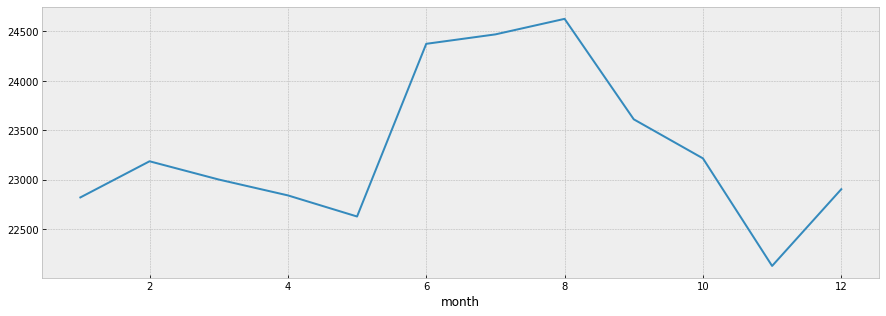

In [ ]:
sale_trend('month','food','median')

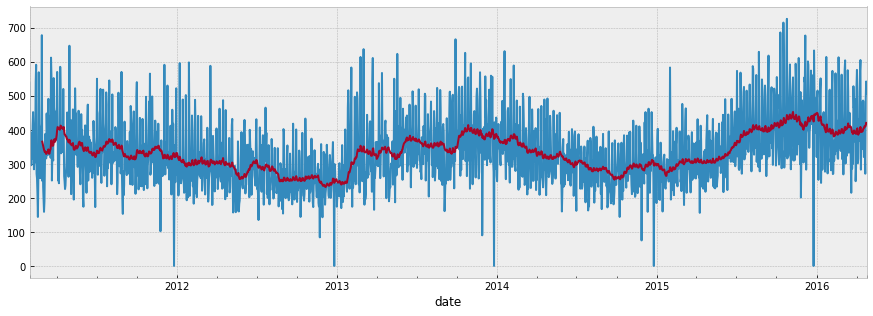

In [ ]:
sale_trend('daily','hobbies_ca_2','sum')

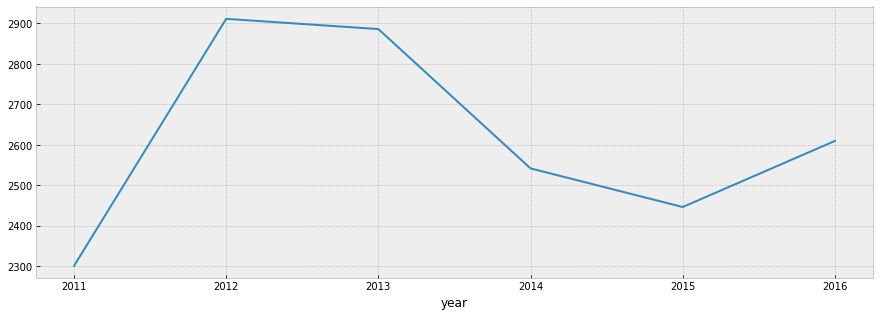

In [ ]:
sale_trend('year','foods_tx_2','mean')

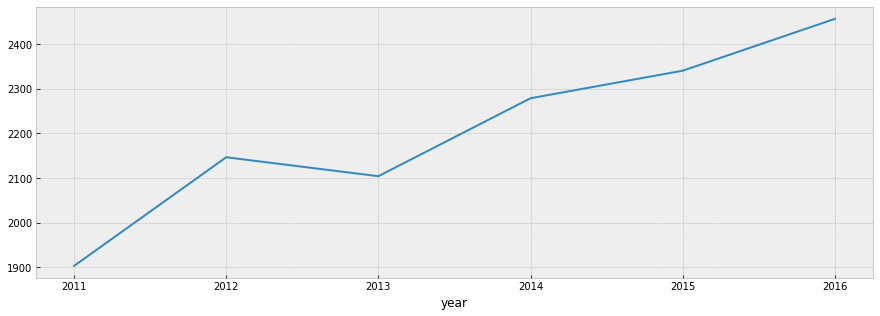

In [ ]:
sale_trend('year','foods_tx_3','mean')

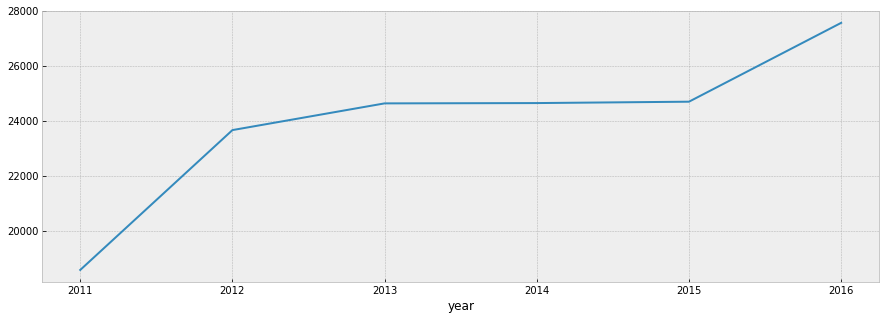

In [ ]:
sale_trend('year','food','mean')

One observation is that whenever sales in texas_2 goes down, sales in texas_3 go up and vice-versa. Maybe one feature we can make is the correlation between between the different store sales and how they are affecting the sales in other stores.

# Price DF and plotting
Up until now all the analysis was in terms of sales patterns alone Now I am trying to add some graphs incorporating the price relations as well.

This section looks lenghty but within cells the code is repetitive, it had to be for the individual categories, so its easier to go through

In [ ]:
#prices_df = pd.read_csv(input_dir+'sales_sell_cal_after_2013.csv')
#prices_df = reduce_mem_usage(df=prices_df, verbose=True)
#print('The shape of prices_df is ', prices_df.shape)
#prices_df.head()



```
# This is formatted as code
```

The above cell is not running because I am unable to upload the file (3.9 Gb) on my drive. I tried uploading the zip file of 303 Mb and then extracting it directly to the drive, but the online feature is either faulty or just doesn't work with such large files

It is really hard to group these together, so I have just grouped them on the basis of the average food, house and hobbies prices, change the category to get different averages

In [ ]:
prices_orig = pd.merge(sell_df,sales_df[['id','item_id', 'dept_id','cat_id']],how = 'left',on='item_id')
prices_orig

,store_id,item_id,wm_yr_wk,sell_price,id,dept_id,cat_id
0,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES
1,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES_1_001_CA_2_validation,HOBBIES_1,HOBBIES
2,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES_1_001_CA_3_validation,HOBBIES_1,HOBBIES
3,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES_1_001_CA_4_validation,HOBBIES_1,HOBBIES
4,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES_1_001_TX_1_validation,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...,...
68411205,WI_3,FOODS_3_827,11621,1.000000,FOODS_3_827_TX_2_validation,FOODS_3,FOODS
68411206,WI_3,FOODS_3_827,11621,1.000000,FOODS_3_827_TX_3_validation,FOODS_3,FOODS
68411207,WI_3,FOODS_3_827,11621,1.000000,FOODS_3_827_WI_1_validation,FOODS_3,FOODS
68411208,WI_3,FOODS_3_827,11621,1.000000,FOODS_3_827_WI_2_validation,FOODS_3,FOODS


In [ ]:
prices = prices_orig.groupby(['cat_id','store_id','wm_yr_wk'])['sell_price'].mean()
prices = prices.unstack(level=1).reset_index()

food_prc = prices[prices['cat_id']=='FOODS']
hobby_prc= prices[prices['cat_id']=='HOBBIES']
house_prc = prices[prices['cat_id']=='HOUSEHOLD']

food_cols = [c for c in calendar.columns if 'food' in c]
hobby_cols = [c for c in calendar.columns if 'hobb' in c]
house_cols = [c for c in calendar.columns if 'house' in c]

In [ ]:
prices

store_id,cat_id,wm_yr_wk,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,FOODS,11101,3.148438,2.876953,3.042969,2.953125,2.949219,2.957031,2.929688,2.759766,2.806641,2.988281
1,FOODS,11102,3.154297,2.878906,3.058594,3.050781,2.982422,2.988281,2.984375,2.802734,2.861328,3.023438
2,FOODS,11103,3.128906,2.869141,3.070312,3.058594,2.984375,2.988281,3.003906,2.832031,2.859375,3.058594
3,FOODS,11104,3.123047,2.861328,3.078125,3.064453,2.984375,2.990234,2.998047,2.822266,2.880859,3.056641
4,FOODS,11105,3.126953,2.853516,3.082031,3.070312,2.974609,2.984375,2.990234,2.820312,2.888672,3.041016
...,...,...,...,...,...,...,...,...,...,...,...,...
841,HOUSEHOLD,11617,5.472656,5.472656,5.468750,5.476562,5.460938,5.464844,5.464844,5.476562,5.468750,5.460938
842,HOUSEHOLD,11618,5.472656,5.468750,5.468750,5.472656,5.460938,5.460938,5.464844,5.476562,5.472656,5.464844
843,HOUSEHOLD,11619,5.472656,5.472656,5.472656,5.472656,5.464844,5.464844,5.464844,5.476562,5.472656,5.464844
844,HOUSEHOLD,11620,5.472656,5.472656,5.472656,5.472656,5.488281,5.460938,5.460938,5.476562,5.472656,5.472656


In [ ]:
#food_prc['dept_id'] = food_prc['dept_id'].astype(string)
food_prc = pd.merge(food_prc,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food_prc.dropna(inplace=True)
hobby_prc = pd.merge(hobby_prc,calendar.groupby('wm_yr_wk')[hobby_cols].mean(),how='left',on='wm_yr_wk')
hobby_prc.dropna(inplace=True)
house_prc = pd.merge(house_prc,calendar.groupby('wm_yr_wk')[house_cols].mean(),how='left',on='wm_yr_wk')
house_prc.dropna(inplace=True)

In [ ]:
food_prc

,cat_id,wm_yr_wk,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,food,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3
0,FOODS,11101,3.148438,2.876953,3.042969,2.953125,2.949219,2.957031,2.929688,2.759766,2.806641,2.988281,19882.000000,2539.142857,1642.857143,3186.000000,1090.571429,1624.428571,2352.714286,1853.857143,1110.142857,1570.142857,2912.142857
1,FOODS,11102,3.154297,2.878906,3.058594,3.050781,2.982422,2.988281,2.984375,2.802734,2.861328,3.023438,20358.571429,2617.000000,1628.857143,3678.857143,1105.142857,1641.571429,2259.000000,1685.571429,1079.142857,1519.000000,3144.428571
2,FOODS,11103,3.128906,2.869141,3.070312,3.058594,2.984375,2.988281,3.003906,2.832031,2.859375,3.058594,18788.285714,2216.428571,1422.285714,2914.428571,1027.000000,1686.714286,2309.285714,1912.142857,997.571429,1433.428571,2869.000000
3,FOODS,11104,3.123047,2.861328,3.078125,3.064453,2.984375,2.990234,2.998047,2.822266,2.880859,3.056641,16361.000000,2122.857143,1371.428571,2689.000000,985.285714,1416.571429,2042.714286,1624.571429,857.714286,1120.285714,2130.571429
4,FOODS,11105,3.126953,2.853516,3.082031,3.070312,2.974609,2.984375,2.990234,2.820312,2.888672,3.041016,17595.857143,2179.000000,1456.857143,2925.142857,1050.857143,1512.571429,2124.285714,1655.142857,933.857143,1259.571429,2498.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,FOODS,11609,3.345703,3.337891,3.328125,3.345703,3.320312,3.322266,3.324219,3.365234,3.365234,3.365234,26659.714286,2928.000000,3022.571429,3967.857143,1681.142857,2038.142857,2583.714286,2362.000000,2472.714286,3059.142857,2544.428571
270,FOODS,11610,3.345703,3.337891,3.330078,3.345703,3.320312,3.320312,3.326172,3.363281,3.365234,3.365234,29789.571429,3198.428571,2958.714286,4199.571429,1755.571429,2166.142857,2666.142857,2495.000000,2636.285714,4628.142857,3085.571429
271,FOODS,11611,3.345703,3.335938,3.332031,3.345703,3.318359,3.320312,3.324219,3.363281,3.365234,3.365234,29903.000000,2978.571429,2976.000000,4067.857143,1707.142857,2145.142857,2650.428571,2638.857143,2849.285714,4674.142857,3215.571429
272,FOODS,11612,3.347656,3.333984,3.333984,3.347656,3.322266,3.322266,3.320312,3.363281,3.365234,3.367188,27322.285714,2977.428571,2832.142857,3782.857143,1777.142857,2160.142857,2529.428571,2426.000000,2639.714286,3474.571429,2722.857143


In [ ]:
274*7
#this is close to the number of days, some weeks might have lesser days and so the difference 

1918

In [ ]:
list_dept = list(prices_orig['dept_id'].unique())
print(list_dept)

['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']


In [ ]:
prices_orig = prices_orig.groupby(['cat_id','store_id','wm_yr_wk', 'dept_id'])['sell_price'].mean()

In [ ]:
prices_orig = prices_orig.unstack(level=1).reset_index()

In [ ]:
food1 = prices_orig[prices_orig['dept_id']=='FOODS_1']
food2 = prices_orig[prices_orig['dept_id']=='FOODS_2']
food3 = prices_orig[prices_orig['dept_id']=='FOODS_3']
hobbies1 = prices_orig[prices_orig['dept_id']=='HOBBIES_1']
hobbies2 = prices_orig[prices_orig['dept_id']=='HOBBIES_2']
house1 = prices_orig[prices_orig['dept_id']=='HOUSEHOLD_1']
house2 = prices_orig[prices_orig['dept_id']=='HOUSEHOLD_2']

In the plot, I will be plotting all of these columns for any particular category

In [ ]:
food_cols

['food',
 'foods_ca_1',
 'foods_ca_2',
 'foods_ca_3',
 'foods_ca_4',
 'foods_tx_1',
 'foods_tx_2',
 'foods_tx_3',
 'foods_wi_1',
 'foods_wi_2',
 'foods_wi_3']

The columns that are required for each of these, can be used from the ones declared above (in the cell of food_prc etc). They don't have to be declared and selected again

In [ ]:
food1_prc = pd.merge(food1,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food1_prc.dropna(inplace=True)
food2_prc = pd.merge(food2,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food2_prc.dropna(inplace=True)
food3_prc = pd.merge(food3,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food3_prc.dropna(inplace=True)
hobby1_prc = pd.merge(hobbies1,calendar.groupby('wm_yr_wk')[hobby_cols].mean(),how='left',on='wm_yr_wk')
hobby1_prc.dropna(inplace=True)
hobby2_prc = pd.merge(hobbies2,calendar.groupby('wm_yr_wk')[hobby_cols].mean(),how='left',on='wm_yr_wk')
hobby2_prc.dropna(inplace=True)
house1_prc = pd.merge(house1,calendar.groupby('wm_yr_wk')[house_cols].mean(),how='left',on='wm_yr_wk')
house1_prc.dropna(inplace=True)
house2_prc = pd.merge(house2,calendar.groupby('wm_yr_wk')[house_cols].mean(),how='left',on='wm_yr_wk')
house2_prc.dropna(inplace=True)

In [ ]:
food1_prc

,cat_id,wm_yr_wk,dept_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,food,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3
0,FOODS,11101,FOODS_1,2.988281,2.998047,2.976562,2.894531,3.011719,3.160156,3.011719,3.162109,3.078125,3.005859,19882.000000,2539.142857,1642.857143,3186.000000,1090.571429,1624.428571,2352.714286,1853.857143,1110.142857,1570.142857,2912.142857
1,FOODS,11102,FOODS_1,3.015625,3.046875,2.966797,3.027344,3.089844,3.113281,3.076172,3.197266,3.177734,3.027344,20358.571429,2617.000000,1628.857143,3678.857143,1105.142857,1641.571429,2259.000000,1685.571429,1079.142857,1519.000000,3144.428571
2,FOODS,11103,FOODS_1,3.000000,3.046875,2.966797,3.015625,3.070312,3.087891,3.058594,3.197266,3.183594,3.107422,18788.285714,2216.428571,1422.285714,2914.428571,1027.000000,1686.714286,2309.285714,1912.142857,997.571429,1433.428571,2869.000000
3,FOODS,11104,FOODS_1,2.976562,3.037109,3.001953,2.988281,3.076172,3.093750,3.058594,3.179688,3.166016,3.076172,16361.000000,2122.857143,1371.428571,2689.000000,985.285714,1416.571429,2042.714286,1624.571429,857.714286,1120.285714,2130.571429
4,FOODS,11105,FOODS_1,2.968750,3.037109,3.001953,2.988281,3.066406,3.093750,3.048828,3.179688,3.216797,3.076172,17595.857143,2179.000000,1456.857143,2925.142857,1050.857143,1512.571429,2124.285714,1655.142857,933.857143,1259.571429,2498.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,FOODS,11609,FOODS_1,3.328125,3.324219,3.312500,3.330078,3.406250,3.410156,3.410156,3.519531,3.519531,3.521484,26659.714286,2928.000000,3022.571429,3967.857143,1681.142857,2038.142857,2583.714286,2362.000000,2472.714286,3059.142857,2544.428571
270,FOODS,11610,FOODS_1,3.330078,3.320312,3.310547,3.330078,3.406250,3.410156,3.410156,3.511719,3.519531,3.519531,29789.571429,3198.428571,2958.714286,4199.571429,1755.571429,2166.142857,2666.142857,2495.000000,2636.285714,4628.142857,3085.571429
271,FOODS,11611,FOODS_1,3.330078,3.322266,3.310547,3.330078,3.410156,3.410156,3.410156,3.519531,3.519531,3.519531,29903.000000,2978.571429,2976.000000,4067.857143,1707.142857,2145.142857,2650.428571,2638.857143,2849.285714,4674.142857,3215.571429
272,FOODS,11612,FOODS_1,3.330078,3.322266,3.316406,3.330078,3.410156,3.398438,3.410156,3.513672,3.519531,3.519531,27322.285714,2977.428571,2832.142857,3782.857143,1777.142857,2160.142857,2529.428571,2426.000000,2639.714286,3474.571429,2722.857143


As a sanity check this works fine. As with the food_prc DataFrame above, the dimensions are the same except for the one extra column of the dept_id. Foods_prc was averaging this across all the departments and hence the lesser column

I am scaling all the eleven columns because I am plotting relative graphs between the food and prices and since the absolute numerical values of the two do not matter, I am removing them here and in plotting.

The first three lines are removing any columns which do not have numerical values in them, and the next set of for loops are setting the column names and targets right, This had become a huge problem while plotting.

The cell after that is pretty much doing the same thing but for the department separated ones

In [ ]:
food_scaled = pd.DataFrame(StandardScaler().fit_transform(food_prc.iloc[:,2:]))
hobby_scaled = pd.DataFrame(StandardScaler().fit_transform(hobby_prc.iloc[:,2:]))
house_scaled = pd.DataFrame(StandardScaler().fit_transform(house_prc.iloc[:,2:]))

l = list(sales_df['store_id'].unique())

for i in range(len(l)):
    food_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food_scaled.rename(columns = {i+10:food_cols[i]},inplace=True)
        
for i in range(len(l)):
    hobby_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(hobby_cols)):
     hobby_scaled.rename(columns = {i+10:hobby_cols[i]},inplace=True)
        
for i in range(len(l)):
    house_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(house_cols)):
     house_scaled.rename(columns = {i+10:house_cols[i]},inplace=True)


In [ ]:
food_scaled

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,food,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3
0,-2.205256,-1.574269,-3.198808,-4.618222,-3.377938,-3.493395,-3.618920,-2.528392,-2.846550,-4.000058,-1.142962,-0.721858,-0.423849,-1.349527,-1.856343,-1.557228,-0.792544,-1.202553,-1.111619,-1.058393,0.890883
1,-2.104078,-1.558816,-2.937798,-3.204027,-2.961848,-3.082241,-2.924099,-2.280443,-2.480251,-3.536996,-0.996182,-0.518479,-0.456489,-0.456133,-1.786019,-1.481326,-1.068045,-1.828660,-1.161483,-1.116877,1.363990
2,-2.542519,-1.636080,-2.742040,-3.090892,-2.937372,-3.082241,-2.675949,-2.111388,-2.493333,-3.073934,-1.479817,-1.564851,-0.938094,-1.841800,-2.163149,-1.281452,-0.920215,-0.985701,-1.292692,-1.214732,0.803012
3,-2.643698,-1.697891,-2.611534,-3.006040,-2.937372,-3.056544,-2.750394,-2.167739,-2.349430,-3.099660,-2.227402,-1.809278,-1.056664,-2.250430,-2.364468,-2.477534,-1.703883,-2.055610,-1.517655,-1.572826,-0.700980
4,-2.576246,-1.759702,-2.546282,-2.921189,-3.059752,-3.133636,-2.849654,-2.179010,-2.297102,-3.305465,-1.847076,-1.662622,-0.857493,-1.822378,-2.048010,-2.052485,-1.464079,-1.941869,-1.395178,-1.413546,0.048543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1.201099,2.072593,1.564634,1.066839,1.272477,1.311957,1.393718,0.965428,0.894930,0.964994,0.944521,0.293915,2.792849,0.067732,0.993846,0.274529,-0.113450,0.687993,1.080103,0.644350,0.141942
270,1.201099,2.072593,1.597261,1.066839,1.272477,1.286260,1.418533,0.954157,0.894930,0.964994,1.908493,1.000328,2.643971,0.487757,1.353049,0.841260,0.128874,1.182819,1.343211,2.438576,1.244113
271,1.201099,2.057140,1.629887,1.066839,1.248001,1.286260,1.393718,0.954157,0.894930,0.964994,1.943428,0.426017,2.684272,0.249001,1.119326,0.748281,0.082677,1.718040,1.685826,2.491179,1.508890
272,1.234825,2.041688,1.662513,1.095123,1.296953,1.311957,1.344088,0.954157,0.894930,0.990719,1.148588,0.423032,2.348880,-0.267614,1.457156,0.814695,-0.273039,0.926105,1.348726,1.119412,0.505356


In [ ]:
food1_scaled = pd.DataFrame(StandardScaler().fit_transform(food1_prc.iloc[:,3:]))
food2_scaled = pd.DataFrame(StandardScaler().fit_transform(food2_prc.iloc[:,3:]))
food3_scaled = pd.DataFrame(StandardScaler().fit_transform(food3_prc.iloc[:,3:]))
hobby1_scaled = pd.DataFrame(StandardScaler().fit_transform(hobby1_prc.iloc[:,3:]))
hobby2_scaled = pd.DataFrame(StandardScaler().fit_transform(hobby2_prc.iloc[:,3:]))
house1_scaled = pd.DataFrame(StandardScaler().fit_transform(house1_prc.iloc[:,3:]))
house2_scaled = pd.DataFrame(StandardScaler().fit_transform(house2_prc.iloc[:,3:]))

for i in range(len(l)):
    food1_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food1_scaled.rename(columns = {i+10:food_cols[i]},inplace=True)
for i in range(len(l)):
    food2_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food2_scaled.rename(columns = {i+10:food_cols[i]},inplace=True)
for i in range(len(l)):
    food3_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food3_scaled.rename(columns = {i+10:food_cols[i]},inplace=True)
        
for i in range(len(l)):
    hobby1_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(hobby_cols)):
     hobby1_scaled.rename(columns = {i+10:hobby_cols[i]},inplace=True)
for i in range(len(l)):
    hobby2_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(hobby_cols)):
     hobby2_scaled.rename(columns = {i+10:hobby_cols[i]},inplace=True)
                
for i in range(len(l)):
    house1_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(house_cols)):
     house1_scaled.rename(columns = {i+10:house_cols[i]},inplace=True)
for i in range(len(l)):
    house2_scaled.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(house_cols)):
     house2_scaled.rename(columns = {i+10:house_cols[i]},inplace=True)

# All the Price Plots

This is again a very robust, versatile and flexible function in my opinion even though the code looks small. It utilizes all the dataframes that I created in the previous section. It has a hell lot of variety.

1. The first argument can be any of the 22 available DataFrames, namely:
      * 3- food_prc, hobby_prc, house_prc
      * 8- food1_prc, ... house2_prc
      * 3- food_scaled, hobby_scaled, house_scaled
      * 8- food1_scaled ...

Later after running the MRP section, those data frames can also be used 
2. The second argument can be any of the 21 available columns; generally the prices at the 10 different stores
3. Again any one of the 21, generally the sales at those stores. It can correspond to the same store or to a different store in case cross connections are to be analysed



NOTE: In the change version of the function, There can be one or more stores and one or more prices

The Blue lines are the relative prices and dotted lines are the sales

In [ ]:
def sales_vs_price(dataset,store_list,sale_list):
    fig,ax = plt.subplots(figsize=(15,5))
    for store in store_list:
        plt.plot(food_prc['wm_yr_wk'],dataset[store],label=store)
    for sales in sale_list:
        plt.plot(food_prc['wm_yr_wk'],dataset[sales].rolling(7).mean(),'--',label=sales)
    fig.legend()
    fig.suptitle('Comparing Price vs Sales')

The overall food prices across all the departments at that store

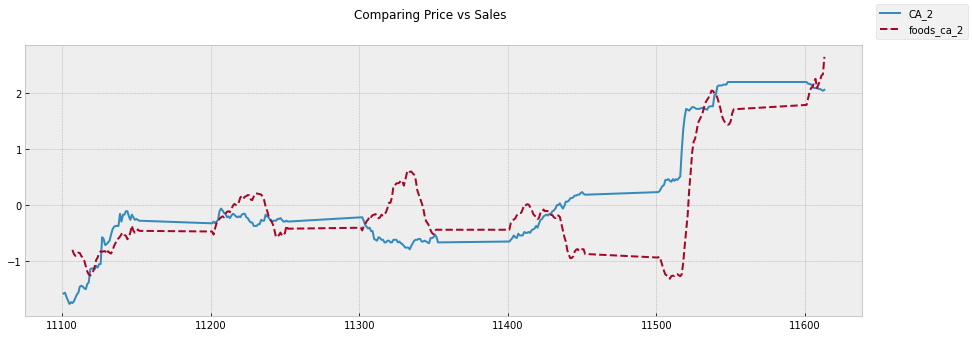

In [ ]:
sales_vs_price(food_scaled,['CA_2'],['foods_ca_2'])

The next three are for the individual food department categories. An important observation:
1. food2 is quite price inelastic, unless the prices become exorbitantly high
2. food1 is relatively more price elastic, but became more inelastic towards the later years
3. food3 is always price elastic, and probably the most amongst them

So one important feature we can add is price elasticity of demand, over the years

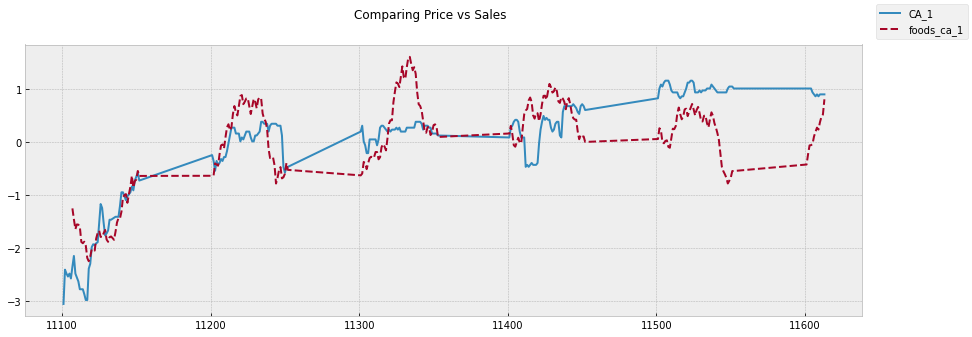

In [ ]:
sales_vs_price(food2_scaled,['CA_1'],['foods_ca_1'])

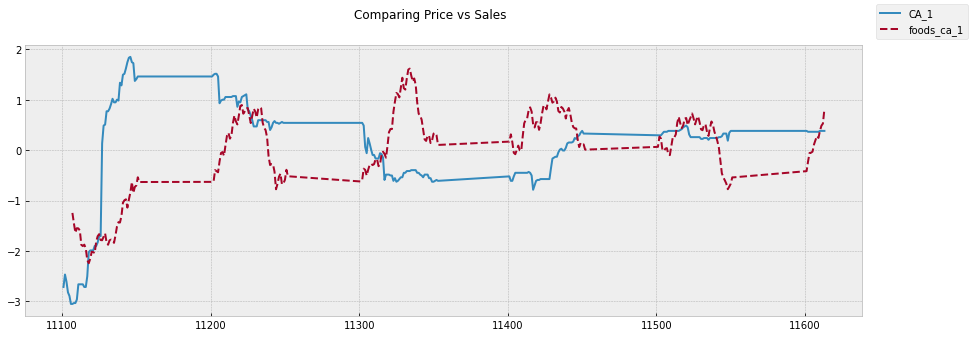

In [ ]:
sales_vs_price(food1_scaled, ['CA_1'], ['foods_ca_1'])

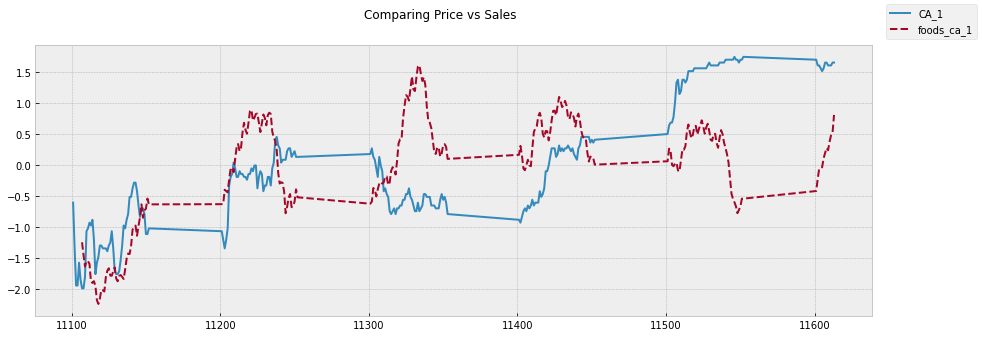

In [ ]:
sales_vs_price(food3_scaled, ['CA_1'], ['foods_ca_1'])

Observe the next two graphs, the demand for the same category of foods is much more price inelastic in tx_3 as compared to tx_2 and tx_1

Since it was kind of observed that food3 is quite price elastic it might be a luxury food. Maybe this means that tx_3 is in a much more posh area as compared to tx_1 and tx_2 which might be in lesser income areas

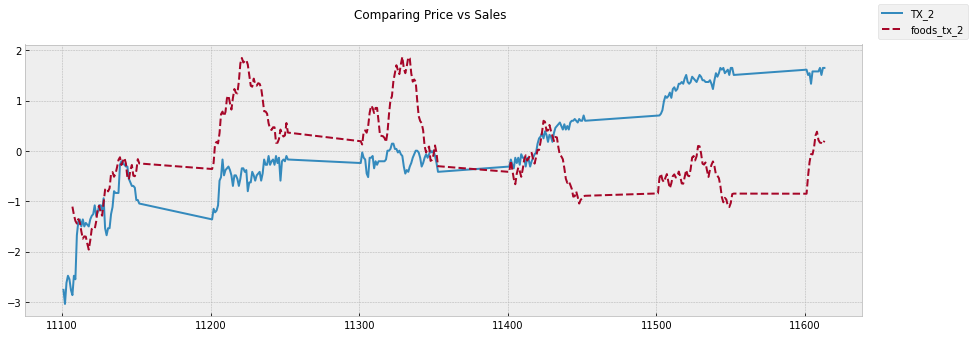

In [ ]:
sales_vs_price(food3_scaled, ['TX_2'], ['foods_tx_2'])

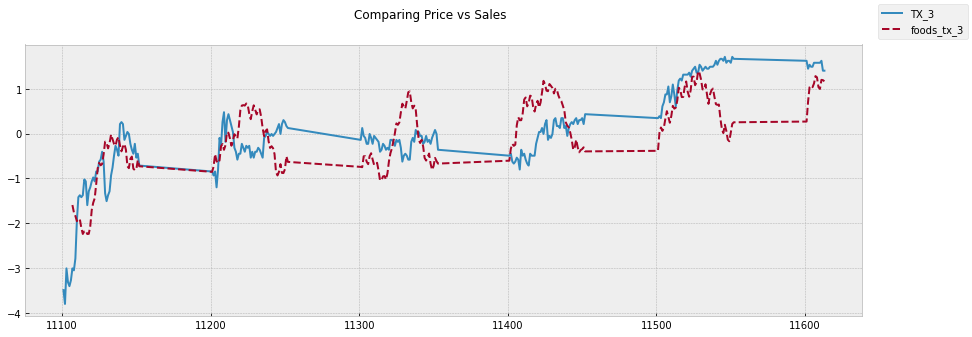

In [ ]:
sales_vs_price(food3_scaled, ['TX_3'], ['foods_tx_3'])

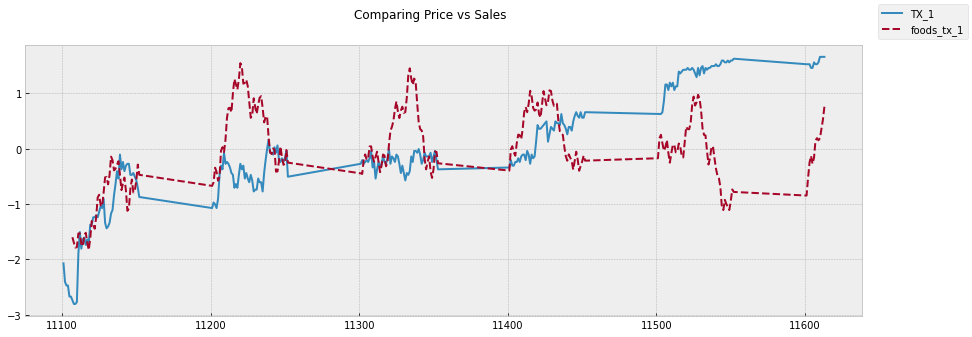

In [ ]:
sales_vs_price(food3_scaled, ['TX_1'], ['foods_tx_1'])

Try and analyze the cross price elasticity demand graphs as well.

# MRP and Discounts

In [ ]:
food1_prc

,cat_id,wm_yr_wk,dept_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,food,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3
0,FOODS,11101,FOODS_1,2.988281,2.998047,2.976562,2.894531,3.011719,3.160156,3.011719,3.162109,3.078125,3.005859,19882.000000,2539.142857,1642.857143,3186.000000,1090.571429,1624.428571,2352.714286,1853.857143,1110.142857,1570.142857,2912.142857
1,FOODS,11102,FOODS_1,3.015625,3.046875,2.966797,3.027344,3.089844,3.113281,3.076172,3.197266,3.177734,3.027344,20358.571429,2617.000000,1628.857143,3678.857143,1105.142857,1641.571429,2259.000000,1685.571429,1079.142857,1519.000000,3144.428571
2,FOODS,11103,FOODS_1,3.000000,3.046875,2.966797,3.015625,3.070312,3.087891,3.058594,3.197266,3.183594,3.107422,18788.285714,2216.428571,1422.285714,2914.428571,1027.000000,1686.714286,2309.285714,1912.142857,997.571429,1433.428571,2869.000000
3,FOODS,11104,FOODS_1,2.976562,3.037109,3.001953,2.988281,3.076172,3.093750,3.058594,3.179688,3.166016,3.076172,16361.000000,2122.857143,1371.428571,2689.000000,985.285714,1416.571429,2042.714286,1624.571429,857.714286,1120.285714,2130.571429
4,FOODS,11105,FOODS_1,2.968750,3.037109,3.001953,2.988281,3.066406,3.093750,3.048828,3.179688,3.216797,3.076172,17595.857143,2179.000000,1456.857143,2925.142857,1050.857143,1512.571429,2124.285714,1655.142857,933.857143,1259.571429,2498.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,FOODS,11609,FOODS_1,3.328125,3.324219,3.312500,3.330078,3.406250,3.410156,3.410156,3.519531,3.519531,3.521484,26659.714286,2928.000000,3022.571429,3967.857143,1681.142857,2038.142857,2583.714286,2362.000000,2472.714286,3059.142857,2544.428571
270,FOODS,11610,FOODS_1,3.330078,3.320312,3.310547,3.330078,3.406250,3.410156,3.410156,3.511719,3.519531,3.519531,29789.571429,3198.428571,2958.714286,4199.571429,1755.571429,2166.142857,2666.142857,2495.000000,2636.285714,4628.142857,3085.571429
271,FOODS,11611,FOODS_1,3.330078,3.322266,3.310547,3.330078,3.410156,3.410156,3.410156,3.519531,3.519531,3.519531,29903.000000,2978.571429,2976.000000,4067.857143,1707.142857,2145.142857,2650.428571,2638.857143,2849.285714,4674.142857,3215.571429
272,FOODS,11612,FOODS_1,3.330078,3.322266,3.316406,3.330078,3.410156,3.398438,3.410156,3.513672,3.519531,3.519531,27322.285714,2977.428571,2832.142857,3782.857143,1777.142857,2160.142857,2529.428571,2426.000000,2639.714286,3474.571429,2722.857143


In [ ]:
food1_mrp = food1_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
food2_mrp = food2_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
food3_mrp = food3_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
hobby1_mrp = hobby1_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
hobby2_mrp = hobby2_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
house1_mrp = house1_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)
house2_mrp = house2_prc.iloc[:, 1:12].cummax(axis=0, skipna=True)

In [ ]:
food1_mrp = pd.merge(food1_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food1_mrp.dropna(inplace=True)
food2_mrp = pd.merge(food2_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food2_mrp.dropna(inplace=True)
food3_mrp = pd.merge(food3_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
food3_mrp.dropna(inplace=True)
hobby1_mrp = pd.merge(hobby1_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
hobby1_mrp.dropna(inplace=True)
hobby2_mrp = pd.merge(hobby2_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
hobby2_mrp.dropna(inplace=True)
house1_mrp = pd.merge(house1_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
house1_mrp.dropna(inplace=True)
house2_mrp = pd.merge(house2_mrp,calendar.groupby('wm_yr_wk')[food_cols].mean(),how='left',on='wm_yr_wk')
house2_mrp.dropna(inplace=True)

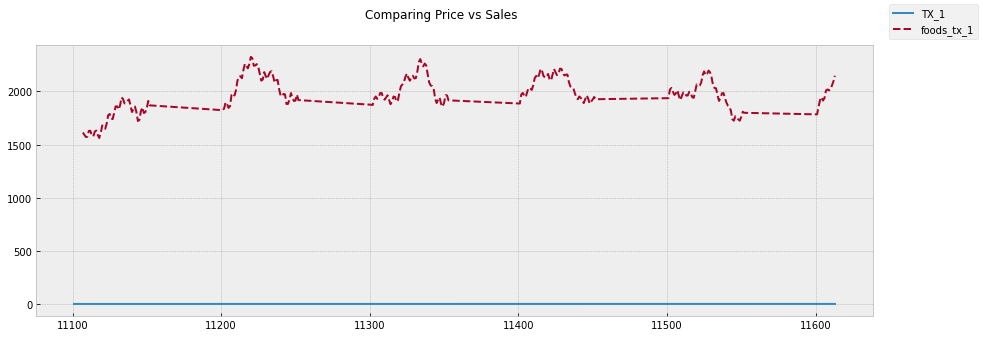

In [ ]:
sales_vs_price(food3_mrp, ['TX_1'], ['foods_tx_1'])

In [ ]:
house1_mrp

,wm_yr_wk,dept_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2
0,11101,HOUSEHOLD_1,4.910156,4.917969,4.925781,4.980469,4.871094,5.054688,4.839844,5.156250,5.132812
1,11102,HOUSEHOLD_1,4.910156,4.921875,4.929688,5.007812,4.968750,5.054688,4.839844,5.156250,5.183594
2,11103,HOUSEHOLD_1,4.937500,4.921875,4.957031,5.062500,4.968750,5.054688,4.886719,5.156250,5.183594
3,11104,HOUSEHOLD_1,4.937500,4.921875,4.957031,5.062500,4.968750,5.054688,4.929688,5.156250,5.183594
4,11105,HOUSEHOLD_1,4.937500,4.925781,5.023438,5.066406,4.968750,5.054688,4.929688,5.160156,5.183594
...,...,...,...,...,...,...,...,...,...,...,...
269,11609,HOUSEHOLD_1,5.191406,5.207031,5.179688,5.199219,5.171875,5.171875,5.171875,5.203125,5.187500
270,11610,HOUSEHOLD_1,5.191406,5.207031,5.179688,5.199219,5.171875,5.171875,5.171875,5.203125,5.187500
271,11611,HOUSEHOLD_1,5.191406,5.207031,5.179688,5.199219,5.171875,5.171875,5.171875,5.203125,5.187500
272,11612,HOUSEHOLD_1,5.191406,5.207031,5.179688,5.199219,5.171875,5.171875,5.171875,5.203125,5.187500


All of these data frames will have to be scaled again !!!!

I am scaling them in place and not creating new ones, as uptil now a lot of ram and memory is already consumed

In [ ]:
food1_mrp = pd.DataFrame(StandardScaler().fit_transform(food1_mrp.iloc[:,2:]))
food2_mrp = pd.DataFrame(StandardScaler().fit_transform(food2_mrp.iloc[:,3:]))
food3_mrp = pd.DataFrame(StandardScaler().fit_transform(food3_mrp.iloc[:,3:]))
hobby1_mrp = pd.DataFrame(StandardScaler().fit_transform(hobby1_mrp.iloc[:,3:]))
hobby2_mrp = pd.DataFrame(StandardScaler().fit_transform(hobby2_mrp.iloc[:,3:]))
house1_mrp = pd.DataFrame(StandardScaler().fit_transform(house1_mrp.iloc[:,3:]))
house2_mrp = pd.DataFrame(StandardScaler().fit_transform(house2_mrp.iloc[:,3:]))

for i in range(len(l)):
    food1_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food1_mrp.rename(columns = {i+10:food_cols[i]},inplace=True)
for i in range(len(l)):
    food2_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food2_mrp.rename(columns = {i+10:food_cols[i]},inplace=True)
for i in range(len(l)):
    food3_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(food_cols)):
     food3_mrp.rename(columns = {i+10:food_cols[i]},inplace=True)
        
for i in range(len(l)):
    hobby1_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(hobby_cols)):
     hobby1_mrp.rename(columns = {i+10:hobby_cols[i]},inplace=True)
for i in range(len(l)):
    hobby2_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(hobby_cols)):
     hobby2_mrp.rename(columns = {i+10:hobby_cols[i]},inplace=True)
                
for i in range(len(l)):
    house1_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(house_cols)):
     house1_mrp.rename(columns = {i+10:house_cols[i]},inplace=True)
for i in range(len(l)):
    house2_mrp.rename(columns = {i:l[i]},inplace=True)
for i in range(0,len(house_cols)):
     house2_mrp.rename(columns = {i+10:house_cols[i]},inplace=True)

This is the same function as defined above, with same options and all but with mrp

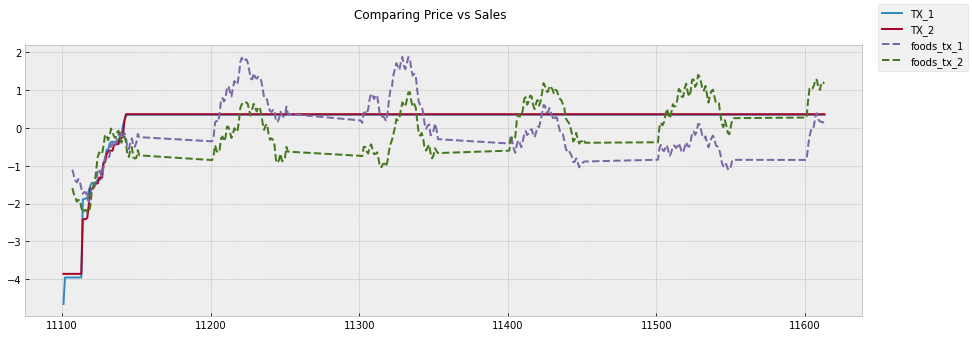

In [ ]:
sales_vs_price(food1_mrp, ['TX_1', 'TX_2'], ['foods_tx_1', 'foods_tx_2'])

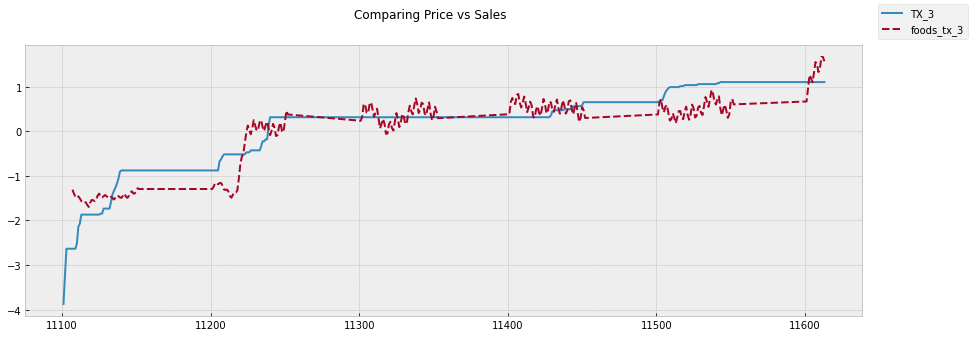

In [ ]:
sales_vs_price(food3_mrp, ['TX_3'], ['foods_tx_3'])

In [ ]:
food1_dis = food1_mrp.iloc[:, 2:] - food1_prc.iloc[:, 3:12]

In [ ]:
food1_dis

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.009766,0.000000,0.000000,0.046875,0.000000,0.000000,0.000000
2,0.015625,0.000000,0.009766,0.011719,0.019531,0.072266,0.017578,0.000000,0.000000
3,0.039062,0.009766,0.000000,0.039062,0.013672,0.066406,0.017578,0.017578,0.017578
4,0.046875,0.009766,0.000000,0.039062,0.023438,0.066406,0.027344,0.017578,0.000000
...,...,...,...,...,...,...,...,...,...
269,0.164062,0.197266,0.142578,0.164062,0.164062,0.177734,0.087891,0.181641,0.058594
270,0.162109,0.201172,0.144531,0.164062,0.164062,0.177734,0.087891,0.189453,0.058594
271,0.162109,0.199219,0.144531,0.164062,0.160156,0.177734,0.087891,0.181641,0.058594
272,0.162109,0.199219,0.138672,0.164062,0.160156,0.189453,0.087891,0.187500,0.058594
